In [4]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=1241242605 seed_offset=0 real_seed=1241242605
core.init.random: RandomGenerator

In [5]:
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import math

In [6]:
def get_energy_landscape(pose, scorefxn, h = 5):
    
    N = int(360/h + 1)
    residues = pose.total_residue()
    Es = np.zeros((N,N))
    
    for res in range(0, residues):
        
        phis = np.arange(-180,180+h,h)
        psis = np.arange(-180,180+h,h)

    for i in range(0,len(phis)):
    
        phi = phis[i]
        pose.set_psi(1, phi)
    
        for j in range(0,len(psis)):
            psi = psis[j]
            pose.set_omega(1, psi)
            E = scorefxn(pose)
        
            Es[i,j] = E

    return Es, phis, psis

In [7]:
def numerical_hessian(Es, h = 5):
    
    N = int(360/h + 1)
    d2E_dphi2 = np.zeros((N,N))
    d2E_dpsi2 = np.zeros((N,N))
    d2E_dphidpsi = np.zeros((N,N))
    r = h*np.pi/180
    
    for i in range(0, len(phis)):

        for j in range(0, len(psis)):
        
            if j == 0:
            
                d2E_dpsi2[i,j] = (Es[i,N-1] - 2*Es[i,j] + Es[i,j+1])/r**2
            
            elif j == N-1:
            
                d2E_dpsi2[i,j] = (Es[i,j-1] - 2*Es[i,j] + Es[i,0])/r**2
        
            else:
            
                d2E_dpsi2[i,j] = (Es[i,j-1] - 2*Es[i,j] + Es[i,j+1])/r**2
        
    for j in range(0, len(phis)):

        for i in range(0, len(psis)):            
            if i == N-1:
            
                d2E_dphi2[i,j] = (Es[i-1,j] - 2*Es[i,j] + Es[0,j])/r**2
        
            else:
            
                d2E_dphi2[i,j] = (Es[i-1,j] - 2*Es[i,j] + Es[i+1,j])/r**2
            
    for i in range(0, len(phis)):
    
        for j in range(0, len(psis)):
        
            if j == 0:
            
                if i == 0:
                
                    d2E_dphidpsi[i,j] = Es[i+1,j+1] - Es[i+1,N-1] - Es[N-1,j+1] + Es[N-1,N-1]
            
                elif i == N-1:
                
                    d2E_dphidpsi[i,j] = Es[0,j+1] - Es[0,N-1] - Es[i-1,j+1] + Es[i-1,N-1]
                
                else:
                
                    d2E_dphidpsi[i,j] = Es[i+1,j+1] - Es[i+1,N-1] - Es[i-1,j+1] + Es[i-1,N-1]
                
            elif j == N-1:
            
                if i == 0:
                
                    d2E_dphidpsi[i,j] = Es[i+1,0] - Es[i+1,N-1] - Es[i-1,0] + Es[i-1,N-1]
            
                elif i == N-1:
                
                    d2E_dphidpsi[i,j] = Es[0,0] - Es[0,j-1] - Es[i-1,0] + Es[i-1,j-1]
                
                else:
                
                    d2E_dphidpsi[i,j] = Es[i+1,0] - Es[i+1,j-1] - Es[i-1,0] + Es[i-1,j-1]
                
            else:
            
                if i == 0:
                
                    d2E_dphidpsi[i,j] = Es[i+1,j+1] - Es[i+1,j-1] - Es[i-1,j+1] + Es[i-1,j-1]
                
                elif i == N-1:
                
                    d2E_dphidpsi[i,j] = Es[0,j+1] - Es[0,j-1] - Es[i-1,j+1] + Es[i-1,j-1]
                
                else:
                
                    d2E_dphidpsi[i,j] = Es[i+1,j+1] - Es[i+1,j-1] - Es[i-1,j+1] + Es[i-1,j-1]
                    
    return d2E_dphi2, d2E_dpsi2, d2E_dphidpsi/4/r**2
                

In [33]:
def hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian


In [25]:
def find_minimum(pose, sf):
    
    minimum = Pose()
    total_residue = pose.total_residue()

    # Random starting config
    pose.set_psi(1, random.uniform(-180.0,180.0))
    pose.set_omega(1, random.uniform(-180.0,180.0))
    
    move_map = MoveMap()
    move_map.set(TorsionID(1, BB, 2), True)
    move_map.set(TorsionID(1, BB, 3), True)

    # Find local minimum
    min_mover = pyrosetta.rosetta.protocols.minimization_packing.MinMover()
    min_mover.score_function(sf)
    min_mover.movemap(move_map)
    min_mover.tolerance(1e-5)
    min_mover.max_iter(1000)
    #min_mover.min_type('dfpmin_armijo_nonmonotone')
    min_mover.apply(pose)
    
    pose.set_psi(1, pose.psi(1)-360.0*round(pose.psi(1)/360.0))
    pose.set_omega(1, pose.omega(1)-360.0*round(pose.omega(1)/360.0))

    minimum.assign(pose)
    # print minimum.phi(1), minimum.psi(1)
    return minimum

In [10]:
def check_minimum(pose, phi_lists, psi_lists):
    
    phi_min = pose.psi(1)
    psi_min = pose.omega(1)
    
    for i in range(0, len(phi_lists)):
        
        phi_list = phi_lists[i]
        psi_list = psi_lists[i]
        
        if phi_min > phi_list[0] and phi_min < phi_list[1] and psi_min > psi_list[0] and psi_min < psi_list[1]:
            
            return True
        
    return False
    

In [11]:
def check_overlap(trial_phis, trial_psis, phi_list, psi_list):
    
    trial_phi_min = trial_phis[0]
    trial_phi_max = trial_phis[1]
    trial_psi_min = trial_psis[0]
    trial_psi_max = trial_psis[1]
        
    phi_min = phi_list[0]
    phi_max = phi_list[1]
    psi_min = psi_list[0]
    psi_max = psi_list[1]
    
    if trial_phi_min > phi_max or phi_min > trial_phi_max:
        return False
        
    if trial_psi_max < psi_min or psi_max < trial_psi_min:
        return False
 
    return True
    

In [12]:
def mode_scan(pose, sf, mode, K, kT = 1.0, h = 5.0):
    
    result = 0
    trial = Pose()
    inc = 0
    max_inc = int(60/h)
    
    E_0 = sf(pose)
    seed = Pose()
    seed.assign(pose)
    seed_energy = 0
    
    V = 1
    
    trial.assign(pose)
    #obs = pyrosetta.rosetta.protocols.moves.AddPyMOLObserver(trial, True)
    trial_energy = sf(pose)
    cutoff = 0.2
    
    phi = pose.psi(1)
    psi = pose.omega(1)
    
    # deform along positive direction
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp(-(trial_energy-E_0)/kT)
        
        trial.set_psi(1, trial.psi(1) - mode[0]*h)
        trial.set_omega(1, trial.omega(1) - mode[1]*h)
        
        seed_energy = sf(trial)
        if abs(seed_energy-E_0) > cutoff or seed_energy < E_0:
            break
            
        if seed_energy < trial_energy:
            
            seed.assign(trial)
            
        trial_energy = seed_energy 
        result += 0.5*np.exp(-(trial_energy-E_0)/kT)

    phi_min = trial.psi(1)
    psi_min = trial.omega(1)
    
    trial.assign(pose)
    trial_energy = sf(pose)
    
    inc = 0
    
    # deform along opposite direction
    while inc < max_inc:
        
        inc +=1 
        
        result += 0.5*np.exp(-(trial_energy-E_0)/kT)
        
        trial.set_psi(1, trial.psi(1) + mode[0]*h)
        trial.set_omega(1, trial.omega(1) + mode[1]*h)
        
        seed_energy = sf(trial)
        if abs(seed_energy-E_0) > cutoff or seed_energy < E_0:
            break
            
        if seed_energy < sf(seed):
            
            seed.assign(trial)
                
        trial_energy = seed_energy 
        result += 0.5*np.exp(-(trial_energy-E_0)/kT)
        
    result *= h*np.pi/180
    phi_max = trial.psi(1)
    psi_max = trial.omega(1)
    #seed.assign(trial)
    V = abs(phi_min-phi_max)*abs(psi_min-psi_max)*np.pi**2/180.0/180.0
    
    #A = -np.log(V*result)
    
    return result, V, seed
            
        

In [13]:
def harmonic_integral(K, kT):
    
    return

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.import_pose.import_pose: File 'alanine-dipeptide-implicit.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom 1HH3 as 1HP2
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom  CH3 as  CP2
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom 2HH3 as 2HP2
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom 3HH3 as 3HP2
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom  C   as  CO
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom  O   as  OP1
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom  N   as  NM
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 4 atoms at position 2 in file alanine-dipeptide-implicit.pdb. Best match rsd_type:  ALA:MethylatedCtermProteinFull:AcetylatedNtermProteinFull
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CN  on residue ALA:MethylatedCtermProteinFull:AcetylatedNtermProteinFull 1
core

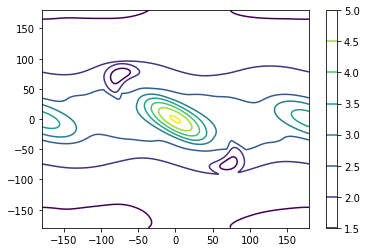

In [34]:
import scipy.interpolate
import matplotlib
import matplotlib.pyplot as plt

scorefxn = get_fa_scorefxn()
pose = pose_from_pdb('alanine-dipeptide-implicit.pdb')

h = 0.5
energy, phis, psis = get_energy_landscape(pose, scorefxn, h)
#d2E_dphi2, d2E_dpsi2, d2E_dphidpsi = numerical_hessian(energy, h)
hessians = hessian(energy, h*np.pi/180)
d2E_dphi2 = hessians[0,0,:,:]
d2E_dpsi2 = hessians[1,1,:,:]
d2E_dphidpsi = hessians[0,1,:,:]
dphi2_fxn = scipy.interpolate.RectBivariateSpline(phis, psis, d2E_dphi2)
dpsi2_fxn = scipy.interpolate.RectBivariateSpline(phis, psis, d2E_dpsi2)
dphidpsi_fxn = scipy.interpolate.RectBivariateSpline(phis, psis, d2E_dphidpsi)

plt.contour(phis, psis, energy)
plt.colorbar()

In [35]:
from pyrosetta.rosetta.core.id import *

energies = np.zeros((2, 100))

for foo in range(0, 100):

    ind = 0
    count = 0
    count_new = count

    minima = []
    phi_lists = []
    psi_lists = []
    A = 0
    Z = 1
    V = 1
    A_old = A
    V_tot = (2*np.pi)**2
    V_sampled = 0

    seed = Pose()

    while True and ind < 15000:

        ind +=1
        Z = 1
        minimum = Pose()

        if seed:

            move_map = MoveMap()
            move_map.set(TorsionID(1, BB, 2), True)
            move_map.set(TorsionID(1, BB, 3), True)

            # Find local minimum
            min_mover = pyrosetta.rosetta.protocols.minimization_packing.MinMover()
            min_mover.score_function(scorefxn)
            min_mover.movemap(move_map)
            min_mover.tolerance(1e-5)
            min_mover.max_iter(1000)
            #min_mover.min_type('dfpmin_armijo_nonmonotone')
            seed.set_psi(1, seed.psi(1)+random.uniform(-30,30))
            seed.set_omega(1, seed.omega(1)+random.uniform(-30,30))
            min_mover.apply(seed)

            seed.set_psi(1, seed.psi(1)-360.0*round(seed.psi(1)/360.0))
            seed.set_omega(1, seed.omega(1)-360.0*round(seed.omega(1)/360.0))

            minimum.assign(seed)
            seed = Pose()

        else:

            minimum.assign(find_minimum(pose, scorefxn))

        phi = minimum.psi(1)
        psi = minimum.omega(1)

        minima.append(minimum)


        # Check that minimum isn't in well already found
        if len(minima) > 1 and check_minimum(minimum, phi_lists, psi_lists):
            minima.pop()
            continue
        
        
        phi_min = max(phi-60, -180)
        phi_max = min(phi+60, 180)
        psi_min = max(psi-60, -180)
        psi_max = min(psi+60, 180)
        
        phi_list = [phi_min, phi_max]
        psi_list = [psi_min, psi_max]
        
        phi_lists.append(phi_list)
        psi_lists.append(psi_list)
        
        # Check that old minimum hasn't been found again 
        if len(minima) > 1:

            for i in range(0, len(minima)-1):

                if check_overlap(phi_list, psi_list, phi_lists[i], psi_lists[i]):


                    count_new += 1
                    minima.pop()

                    phi_lists.pop()
                    psi_lists.pop()

                    break

        if count_new > count:

            count = count_new

            continue

        hess = np.zeros((2,2))

        # Calculate hessian at base of well
        hess[0,0] = dphi2_fxn(phi, psi)
        hess[0,1] = dphidpsi_fxn(phi, psi)
        hess[1,0] = hess[0,1]
        hess[1,1] = dpsi2_fxn(phi, psi)

        # Diagonalization of hessian
        w, v = scipy.linalg.eigh(hess)

        # Discard wells with non-positive definite hessian 
        if w[0]*w[1] < 0 or (w[0] < 0 and w[1] < 0):
            minima.pop()
            phi_lists.pop()
            psi_lists.pop()
            continue

        print phi, psi
        from scipy.special import erf
        for i in range(0,len(w)):

            K = w[i]

            # Mode scan for soft degrees of freedom
            if K < 10.0:

                Z_j, V_j, seed = mode_scan(minimum, scorefxn, v[:,i], K, 1.0, 0.5)
                sig = np.sqrt(1.0/K)
                interval = min(2*sig, np.pi/3)
                Z_i = np.sqrt(2*np.pi)*sig*scipy.special.erf(interval/np.sqrt(2/K))
                Z *= Z_j

                print Z_i, Z_j

            # Harmonic integration
            else:

                sig = np.sqrt(1.0/K)
                interval = min(3*sig, np.pi/3)         
                Z *= np.sqrt(2*np.pi)*sig*scipy.special.erf(interval/np.sqrt(2/K))

        A += Z
        Z = 1
            
        V_sampled += abs(phi_list[1]-phi_list[0])*abs(psi_list[1]-psi_list[0])*np.pi**2/180/180
        print w
        print phi_list, psi_list
        print -np.log(A)
        print len(minima)

        # check convergence criterion
        if abs(A_old-A)/A_old < 0.001:
            
            break
            
        A_old = A

    print -np.log(A)
    
    energies[0, foo] = len(minima)
    energies[1, foo] = -np.log(A)

/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: Pose.__len__ is deprecated, prefer 'pose.residues.__len__'.
/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: divide by zero encountered in double_scalars


-178.821436091 115.693734259
2.0821549491 1.03361706469
1.90404132569 0.846315139793
[ 0.03214512  0.54243699]
[-180, -118.82143609065176] [55.69373425914064, 175.69373425914063]
0.133799119208
1
-172.372534755 -177.536896732
2.0749605325 1.04723925985
1.97087675497 0.992973907866
[ 0.05119869  0.34098004]
[-180, -112.37253475490877] [-180, -117.53689673233816]
-0.649533287588
2
-163.777074296 -40.8342394689
2.08966896264 1.02360972247
2.01678083884 0.990160181888
[ 0.01237158  0.20980418]
[-180, -103.77707429647165] [-100.83423946888729, 19.16576053111271]
-1.07438264736
3
178.430825031 118.671948654
2.08255842491 1.03433587804
1.86975347279 0.802547813332
[ 0.03108009  0.65102973]
[118.43082503056698, 180] [58.67194865370003, 178.67194865370004]
-1.32396369876
4
177.108796274 -45.5402675853
2.09144703307 1.02462278742
1.86660175611 0.707041213321
[ 0.00771123  0.66120111]
[117.10879627373637, 180] [-105.5402675852635, 14.459732414736486]
-1.50023427831
5
177.893230176 -174.92147622
2

-1.7349133225
-176.263176166 -105.759066547
2.09191800647 1.04674192337
1.93321076031 0.809730487019
[ 0.006478    0.45291395]
[-180, -116.2631761662976] [-165.75906654690834, -45.75906654690834]
0.165371408783
1
-172.402516457 178.598017163
2.07506583314 1.04698765892
1.97061606591 0.993179645275
[ 0.05091895  0.34174108]
[-180, -112.40251645658117] [118.59801716257505, 180]
-0.635213826047
2
179.706145583 97.6547677382
2.08243385202 1.02981852457
1.96194036206 0.859294413937
[ 0.03140888  0.36717522]
[119.7061455831413, 180] [37.654767738226354, 157.65476773822635]
-1.0196928055
3
179.833446417 -162.978374644
2.08704368439 0.696532661948
1.98085303834 0.825033609292
[ 0.01926556  0.31199524]
[119.83344641741985, 180] [-180, -102.9783746435125]
-1.20806616728
4
27.9822856536 -75.4780505267
2.08014048359 0.872968784794
1.45075145006 0.9534953233
[ 0.0374682   2.38813289]
[-32.0177143463616, 87.9822856536384] [-135.4780505266593, -15.478050526659302]
-1.43016231066
5
26.5803616293 98.36

32.084993907 -162.599676918
2.08840945978 0.668058268311
0.997327347967 0.137992876415
[ 0.01567708  5.75514192]
[-27.91500609298533, 92.08499390701468] [-180, -102.59967691806227]
-1.52283499425
8
-1.52283499425
-166.849029198 -63.7411949809
2.05028210306 1.02041699943
1.99818681926 0.994217370756
[ 0.11747537  0.26226999]
[-180, -106.84902919783835] [-123.74119498088143, -3.7411949808814313]
-0.0144119533389
1
-173.690978865 141.795787989
2.08923853903 1.04110492002
1.95475284811 0.993068860921
[ 0.0135008   0.38840512]
[-180, -113.6909788645811] [81.79578798921915, 180]
-0.717061531004
2
176.729894895 119.302525054
2.08171258872 1.03447151861
1.8484631198 0.776887419902
[ 0.03331323  0.72038073]
[116.72989489530437, 180] [59.30252505375178, 179.30252505375176]
-1.04804613067
3
178.169330851 -114.640819005
2.08578490292 1.04814063162
1.8691020516 0.760784472205
[ 0.02257666  0.65312936]
[118.16933085143614, 180] [-174.64081900457063, -54.64081900457063]
-1.29458529713
4
-24.307974184

177.729577528 -179.309201189
2.07763556249 1.04666976015
1.868381039 0.798988979563
[ 0.04410027  0.65545491]
[117.72957752835995, 180] [-180, -119.3092011887176]
-1.67524820396
6
-22.9768367408 -32.9160217858
2.07902280761 0.958392903131
0.880761694046 0.138722410613
[ 0.04042559  7.37929135]
[-82.97683674080126, 37.02316325919874] [-92.91602178584134, 27.08397821415867]
-1.69983988439
7
27.1543400019 96.5340844076
2.04194546324 0.917548483046
1.71234747263 0.255540253775
[ 0.14019275  1.20306242]
[-32.845659998109454, 87.15434000189055] [36.5340844076497, 156.5340844076497]
-1.74178838274
8
31.5513570102 -157.404422104
2.08020160838 0.6124705843
1.21015524106 0.170912820189
[ 0.03730655  3.90885285]
[-28.448642989786418, 91.55135701021358] [-180, -97.40442210423126]
-1.7599627086
9
-1.7599627086
-178.019925921 -53.1447305369
2.08148513573 1.02237844821
1.92621203525 0.745832787249
[ 0.03391402  0.47416173]
[-180, -118.01992592091833] [-113.14473053689669, 6.855269463103312]
0.2711221

45.9603143985 106.476838514
1.95789004056 0.400896063016
1.78073164499 0.30559550144
[ 0.37912093  0.95158012]
[-14.03968560154474, 105.96031439845527] [46.47683851372767, 166.47683851372767]
-1.23311589773
6
177.374623862 -174.341686601
2.07523747706 1.04713246129
1.86490786614 0.79811132204
[ 0.05046303  0.66668122]
[117.37462386160092, 180] [-180, -114.34168660086306]
-1.45105972433
7
-1.45105972433
-177.342734578 -175.506574367
2.07525886462 1.04728625346
1.93164454037 0.861699560196
[ 0.05040622  0.45765641]
[-180, -117.34273457830372] [-180, -115.50657436675954]
0.102646309113
1
-175.85455027 173.72353412
2.07518372717 1.04679996361
1.94455737585 0.88772300556
[ 0.05060579  0.41876992]
[-180, -115.85455027048249] [113.72353411995522, 180]
-0.605252421095
2
178.38209945 84.371336568
2.08621356772 1.02989229008
1.8708310496 0.864607718592
[ 0.02144869  0.64755959]
[118.38209944983768, 180] [24.371336568021775, 144.37133656802177]
-1.00142837818
3
-167.872380064 -39.4812748324
2.092

-43.1218970167 -41.1203423624
1.99489665188 0.268926727087
1.42463811595 0.354550019465
[ 0.27164723  2.53183371]
[-103.12189701666868, 16.878102983331317] [-101.12034236241675, 18.879657637583257]
-1.56826110814
7
167.310212642 -179.038385705
2.0745412779 1.04599079978
1.78297468282 0.72711983384
[ 0.05231272  0.94365166]
[107.31021264242577, 180] [-180, -119.03838570536251]
-1.7153926684
8
-1.7153926684
-172.420486997 -56.377743439
2.07609659718 1.02137868496
1.96991810251 0.825157146028
[ 0.04818203  0.34377959]
[-180, -112.42048699656405] [-116.37774343902817, 3.6222565609718416]
0.17102806419
1
-170.453254184 165.328377024
2.07422190642 1.04508932394
1.9814962374 0.988425200661
[ 0.05316161  0.31013577]
[-180, -110.45325418403519] [105.32837702391197, 180]
-0.629030194788
2
-176.964014994 -179.650858292
2.08171470518 1.04693166134
1.93511425956 0.870023459597
[ 0.03330764  0.44715989]
[-180, -116.96401499401827] [-180, -119.65085829153873]
-1.02483859703
3
162.827758316 104.425703

39.8574645576 -79.2486226288
2.08481812542 0.079835538264
[  2.51221241e-02   3.73730643e+01]
[-20.142535442386283, 99.85746455761372] [-139.24862262881786, -19.248622628817856]
-1.47386364704
6
161.622065425 -178.78868904
2.07318977217 1.04585243181
1.82189047199 0.720510708919
[ 0.05590666  0.80911062]
[101.62206542459933, 180] [-180, -118.78868903981379]
-1.63308010654
7
32.3613351023 93.5302530595
1.98594092631 0.517122353435
1.77031036987 0.239253340632
[ 0.29731669  0.98867291]
[-27.63866489767664, 92.36133510232335] [33.53025305953035, 153.53025305953037]
-1.65695921141
8
-1.65695921141
-175.740954931 -173.900813124
2.07553156509 1.04761492993
1.94564607967 0.88787120001
[ 0.04968202  0.41551334]
[-180, -115.74095493074861] [-180, -113.9008131239155]
0.0724125064392
1
-174.784861967 172.930919014
2.07504768548 1.0465534551
1.95317491507 1.89571402094
[ 0.05096716  0.39308533]
[-180, -114.78486196728525] [112.93091901438808, 180]
-1.06956554829
2
-168.52139826 -45.8739369542
2.08

-42.6588181261 -44.3769583183
1.9755268633 0.301262936889
1.33369676622 0.320122641982
[ 0.32743607  3.08126462]
[-102.65881812611566, 17.341181873884338] [-104.37695831827665, 15.62304168172335]
-1.5221125883
6
26.6852336683 100.159277836
2.05774883456 0.406893246128
1.59524231207 0.312076233511
[ 0.09727057  1.68375488]
[-33.314766331706124, 86.68523366829388] [40.15927783611545, 160.15927783611545]
-1.54944931194
7
-1.54944931194
-177.850917814 -161.719170185
2.09057064535 0.635691404921
1.92534805088 0.852677804108
[ 0.01000737  0.47679477]
[-180, -117.85091781386097] [-180, -101.71917018472737]
0.612415569488
1
-179.905248546 74.2516158137
2.09091950161 1.03150191586
1.99020920022 0.913808826737
[ 0.00909316  0.28505614]
[-180, -119.90524854589353] [14.251615813744792, 134.2516158137448]
-0.395169292123
2
177.750898511 138.730835385
2.08564188216 1.04052017888
1.86244748567 0.777823625754
[ 0.02295309  0.67465799]
[117.75089851116604, 180] [78.73083538468833, 180]
-0.830286855162


-25.9509685441 -28.3059770587
2.05893186314 0.951112897292
0.849336263101 0.130296824449
[ 0.09408154  7.93546096]
[-85.95096854406243, 34.049031455937566] [-88.30597705871367, 31.694022941286335]
-1.2935726305
5
25.3270295744 99.7476091976
2.08595149461 0.459184558342
1.57892262954 0.288355735785
[ 0.02213825  1.75652592]
[-34.672970425621465, 85.32702957437854] [39.74760919760635, 159.74760919760635]
-1.32924687797
6
31.2568966443 -157.877586865
2.08430724803 0.634952799494
1.15785430541 0.162765534809
[ 0.02646809  4.2699586 ]
[-28.743103355697038, 91.25689664430297] [-180, -97.87758686488425]
-1.3562333487
7
-1.3562333487
-173.625563066 -80.3128138405
2.05584228197 1.0301569781
1.95572086638 0.807582806448
[ 0.10241699  0.38553742]
[-180, -113.62556306579259] [-140.31281384048384, -20.312813840483855]
0.183998485904
1
-177.241326548 175.470230499
2.07535576125 1.04695790158
1.93252637514 0.862131334753
[ 0.05014888  0.45498536]
[-180, -117.24132654811314] [115.47023049856281, 180]


KeyboardInterrupt: 

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt

Text(0,0.5,'Count')

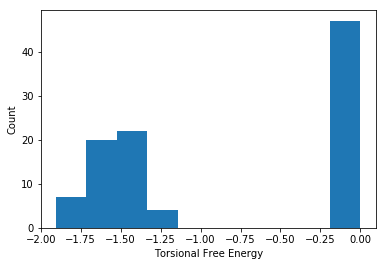

In [37]:
plt.hist(energies[1,:], 10)
plt.xlabel('Torsional Free Energy')
plt.ylabel('Count')

In [38]:
print np.mean(energies[1,:]), np.std(energies[1,:])

-0.815698259925 0.77549116953


[[ 8.          8.          8.          8.          8.          8.          8.
   8.          8.          8.          8.          8.          8.        ]
 [-1.71811603 -1.42114707 -1.52283499 -1.66636111 -1.85725716 -1.71759977
  -1.40571478 -1.71539267 -1.66500809 -1.40295173 -1.65695921 -1.63315577
  -1.67353674]]


(array([ 1.,  0.,  0.,  3.,  5.,  0.,  0.,  1.,  0.,  3.]),
 array([-1.85725716, -1.81182662, -1.76639608, -1.72096553, -1.67553499,
        -1.63010445, -1.5846739 , -1.53924336, -1.49381282, -1.44838227,
        -1.40295173]),
 <a list of 10 Patch objects>)

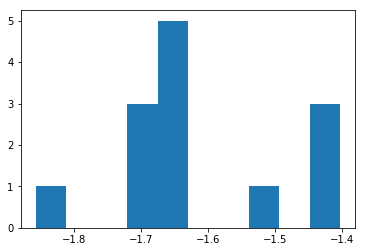

In [40]:
b = energies[0,:] == 8
indices = np.stack((b,b))
sampled_energies = energies[indices]
sampled_energies = sampled_energies.reshape((2,len(sampled_energies)/2))
print sampled_energies
plt.hist(sampled_energies[1,:], 10)

In [41]:
print np.average(sampled_energies[1,:]), np.std(sampled_energies[1,:])

-1.61969501017 0.134488758069
